In [1]:
import sklearn
import mglearn
import numpy as np
import matplotlib.pyplot as plt

/home/inory/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/inory/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 数据集准备

## 说明

数据集信息

- 示例使用LMDb（Internet Movie Database，互联网电影数据库）电影评论数据集
- 数据集下载地址http://ai.stanford.edu/~amaas/data/sentiment/
- 这里使用的1.0版本数据集，与书中不同，文件夹位置：`data/aclImdb_v1/aclImdb`
- 为电影情感二分类任务，将lmdb中小于7的评分作为负样本`neg`,大于等于7分的（7～10）作为正样本`pos`

数据集内容

- 监督学习提供50k标记的样本，正样本`pos`和负样本`neg`中各有25k
- 数据集还包括用于非监督学习的50k未标记的样本,之后将unsup文件夹移动到根目录下

## 查看文件树

In [2]:
!tree -L 1 data/aclImdb_v1/aclImdb/

data/aclImdb_v1/aclImdb/
├── imdbEr.txt
├── imdb.vocab
├── README
├── test
├── train
└── unsup

3 directories, 3 files


## 载入数据集

text_train, y_train

text_test, y_test

In [3]:
from sklearn.datasets import load_files

reviews_train = load_files('data/aclImdb_v1/aclImdb/train/')

text_train, y_train = reviews_train.data, reviews_train.target
print('type of text_train:', type(text_train))
print('length of text_train:', len(text_train))
print('train sample 0:\n', text_train[0])

type of text_train: <class 'list'>
length of text_train: 25000
train sample 0:
 b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."


清洗数据

In [4]:
text_train = [doc.replace(b'<br />', b' ') for doc in text_train]
print('train sample 0:\n', text_train[0])

train sample 0:
 b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.  It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see.   Flawed but honest with a terrible honesty."


In [5]:
print('samples per class(training):', np.bincount(y_train))

samples per class(training): [12500 12500]


加载测试数据

In [6]:
reviews_test = load_files('data/aclImdb_v1/aclImdb/test/')
text_test, y_test = reviews_test.data, reviews_test.target
text_test = [doc.replace(b'<br />', b' ') for doc in text_test]
print('length of text_test:', len(text_test))
print('samples per class(training):', np.bincount(y_test))
print('train sample 0:\n', text_test[0])

length of text_test: 25000
samples per class(training): [12500 12500]
train sample 0:
 b"Don't hate Heather Graham because she's beautiful, hate her because she's fun to watch in this movie. Like the hip clothing and funky surroundings, the actors in this flick work well together. Casey Affleck is hysterical and Heather Graham literally lights up the screen. The minor characters - Goran Visnjic {sigh} and Patricia Velazquez are as TALENTED as they are gorgeous. Congratulations Miramax & Director Lisa Krueger!"


# 文本数据表示：词袋模型（bow）

只统计每个单词在每个文本的出现频次

具体流程包括：
- 分词
- 构建词表
- 编码

词袋编码的一个例子如下图：

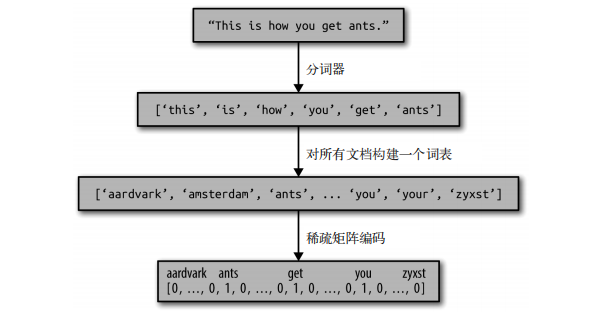

## 词袋模型的应用例子

CountVectorizer用于：
 - 读取文档列表
 - 构造词典（fit）
 - 转换文档为词袋（transform）
 
 默认分割单词的正则为"\b\w\w+\b"，匹配被分割边界包围的两个以上单词符号组成的单词
 
 -b表示单词边界，即单词符号与非单词符号的边界
 -w表示单词符号

In [7]:
# 待处理的文档列表
bard_words = ['The fool doth think he is wise,',
              'but the wise man knows himself to be a fool']
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bard_words)

print('vocabulary size:', len(vect.vocabulary_))
# 测试中发现CountVectorizer会将标点当做分隔符处理
print('vocabulary content:', vect.vocabulary_)
feature_names = vect.get_feature_names()
print('feature name:', feature_names)

vocabulary size: 13
vocabulary content: {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}
feature name: ['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


构建输入的词袋表示

In [8]:
bag_of_words = vect.transform(bard_words)

# 词袋以SciPy稀疏矩阵表示， 可以使用toarray()转化为普通表示
print('Sparse representation of bag_of_words:\n', bag_of_words)
print('Dense representation of bag_of_words:\n', bag_of_words.toarray())

Sparse representation of bag_of_words:
   (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 6)	1
  (0, 9)	1
  (0, 10)	1
  (0, 12)	1
  (1, 0)	1
  (1, 1)	1
  (1, 3)	1
  (1, 5)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  (1, 11)	1
  (1, 12)	1
Dense representation of bag_of_words:
 [[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


## 将词袋模型应用于IMDb

In [9]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)

# (25000, 74849)
print('X_train info:\n', repr(X_train))
feature_names = vect.get_feature_names()
print('num of features:', len(feature_names))
print('First 20 features:\n', feature_names[:20])
print('2000-20020 features:\n', feature_names[20000: 20020])
print('Every 2000th feature:\n', feature_names[::2000])

X_train info:
 <25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>
num of features: 74849
First 20 features:
 ['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
2000-20020 features:
 ['draper', 'draperies', 'drapery', 'drapes', 'draskovic', 'drastic', 'drastically', 'drat', 'dratch', 'dratic', 'dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers']
Every 2000th feature:
 ['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'tempta

### 直接应用LogisticRegression

对于高维数据，使用交叉验证与Logistic回归进行预测

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(solver='liblinear'),
                         X_train, y_train, cv=5)
print('LR cv scores:', scores)
print('average score:', np.mean(scores))

LR cv scores: [0.8824 0.876  0.8822 0.8884 0.8776]
average score: 0.88132


使用网格搜索查找最优参数

In [11]:
# 大约需要两分钟
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid.fit(X_train, y_train)
print('Best cv score:', grid.best_score_)
print('Best parameter:', grid.best_params_)

Best cv score: 0.88816
Best parameter: {'C': 0.1}


验证模型

In [12]:
X_test = vect.transform(text_test)
print('evaluate score:', grid.score(X_test, y_test))

evaluate score: 0.87892


### 去掉出现次数较少的单词

In [13]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

print('X_train with min_df=5:', repr(X_train))

X_train with min_df=5: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [14]:
feature_names = vect.get_feature_names()
print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciati

In [15]:
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: ", grid.best_score_)

Best cross-validation score:  0.88812


## 停用词

In [16]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print('num of stop words:',len(ENGLISH_STOP_WORDS))
print('every 10th stopword', list(ENGLISH_STOP_WORDS)[::10])

num of stop words: 318
every 10th stopword ['hundred', 'cant', 'many', 'since', 'hereby', 'hasnt', 'thereby', 'whether', 'less', 'everywhere', 'very', 'i', 'along', 'thus', 'too', 'already', 'or', 'after', 'most', 'through', 'becomes', 'beyond', 'those', 'four', 'yet', 'seem', 'of', 'among', 'him', 'here', 'perhaps', 'eight']


In [17]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train) 
X_train = vect.transform(text_train) 
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [18]:
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5) 
grid.fit(X_train, y_train) 
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.88


# 文本表示 tf-idf

**词频-逆文档向频率**（term frequency-inverse document frequency, tf-idf）。

$$
tf-idf = TF * IDF
$$

tf-idf分数与其在当前文档中的出现频率正相关，与在所有文档中的出现频率负相关

sklearn 提供了两种tf-idf方法, 并对结果应用L2范数将每个文档的表示缩放到L2范数为1：
- TfidfTransformer 接受CountVectorizer生成的稀疏矩阵并变换
- TfidfVectorizer 输入文档并完成词袋特征提取与tf-idf变换

具体的tf-idf计算公式如下：
$$
tfidf(w,d) = tf * log \frac{N+1}{N_w + 1} + 1
$$

## tf-idf的例子

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
# 待处理的文档列表
bard_words = ['The fool doth think he is wise,',
              'but the wise man knows himself to be a fool']

tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(bard_words)

print('vocabulary size:', len(tfidf_vect.vocabulary_))
# 测试中发现CountVectorizer会将标点当做分隔符处理
print('vocabulary content:', tfidf_vect.vocabulary_)
feature_names = tfidf_vect.get_feature_names()
print('feature name:', feature_names)
print('tfidf features of docs：\n', tfidf_vect.transform(bard_words).toarray())

vocabulary size: 13
vocabulary content: {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}
feature name: ['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']
tfidf features of docs：
 [[0.         0.         0.42567716 0.30287281 0.42567716 0.
  0.42567716 0.         0.         0.30287281 0.42567716 0.
  0.30287281]
 [0.36469323 0.36469323 0.         0.25948224 0.         0.36469323
  0.         0.36469323 0.36469323 0.25948224 0.         0.36469323
  0.25948224]]


## tf-idf 应用于IMDb

In [20]:
# 3分钟
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5),
                     LogisticRegression(solver='liblinear'))

param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print('Best cross-validation score:', grid.best_score_)

Best cross-validation score: 0.89188


### 编码分析

In [21]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
tfidf_X = vectorizer.transform(text_train)
# 找到变换后每个特征的最大值
max_value = tfidf_X.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# 获取特征名称
feature_names = np.array(vectorizer.get_feature_names())

print('features with lowest tfidf:\n',
      feature_names[sorted_by_tfidf[: 20]])

print('features with highest tfidf:\n',
      feature_names[sorted_by_tfidf[-20:]])

features with lowest tfidf:
 ['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
features with highest tfidf:
 ['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


查看逆文档分数比较低的单词，即在大量文档中出现的单词

In [22]:
idf = vectorizer.idf_
print('print features with lowest idf:\n',
      feature_names[np.argsort(idf)[:50]])

print features with lowest idf:
 ['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very']


### 模型系数分析

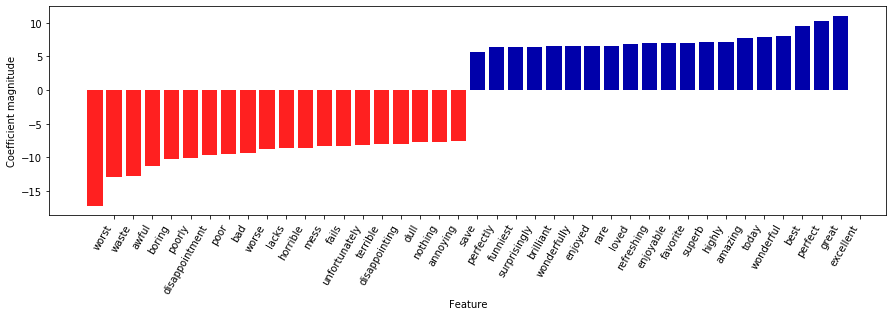

In [23]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_,
    feature_names,
    n_top_features=20
)

# 多元分词

## 使用示例

词袋完全舍去了次序信息，如"It's bad, not good at all"句子"It's good, not bad at all"
的词袋编码完全相同

- 使用二元分词(bigram)，三元分词（trigram）， 多元分词一定程度上解决次序问题，提供更丰富的语义表示
- 通过设置ngram_range参数，表示分词范围

In [24]:
print('bard_words:\n', bard_words)

bard_words:
 ['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [25]:
bow_vect = CountVectorizer(ngram_range=(1,2)).fit(bard_words)
print('Vocabulary size:', len(bow_vect.vocabulary_))
print('Vocabulary:', bow_vect.get_feature_names())

print('Transformed data:\n', bow_vect.transform(bard_words).toarray())

Vocabulary size: 27
Vocabulary: ['be', 'be fool', 'but', 'but the', 'doth', 'doth think', 'fool', 'fool doth', 'he', 'he is', 'himself', 'himself to', 'is', 'is wise', 'knows', 'knows himself', 'man', 'man knows', 'the', 'the fool', 'the wise', 'think', 'think he', 'to', 'to be', 'wise', 'wise man']
Transformed data:
 [[0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0]
 [1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1]]


## 应用于tfidb表示的IMDb数据集

In [26]:
# 为了节省时间，将原书中C的范围，与交叉验证的折数减小
# 8分钟
pipe = make_pipeline(TfidfVectorizer(min_df=5),
                     LogisticRegression(solver='liblinear'))
param_grid = {'logisticregression__C': [1, 10, 100],
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=3)
grid.fit(text_train, y_train)
print('Best cross-validation score:', grid.best_score_)
print('Best parameters:', grid.best_params_) 

Best cross-validation score: 0.90148
Best parameters: {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


通过热图查看参数选择结果

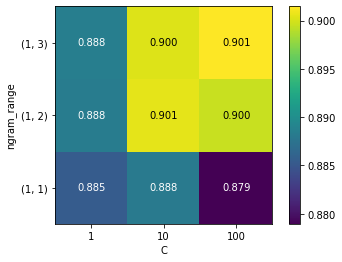

In [27]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# 热图可视化
heatmap = mglearn.tools.heatmap(
    scores, xlabel='C', ylabel='ngram_range', cmap='viridis',
    fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range']
)
plt.colorbar(heatmap)
plt.show()

查看特征系数

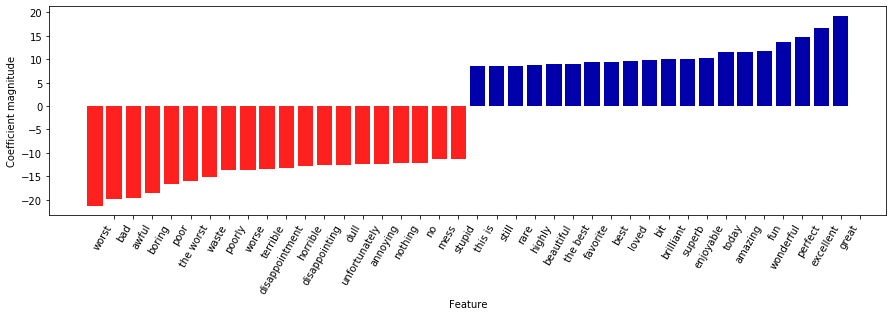

In [28]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(
    coef,
    feature_names,
    n_top_features=20
)

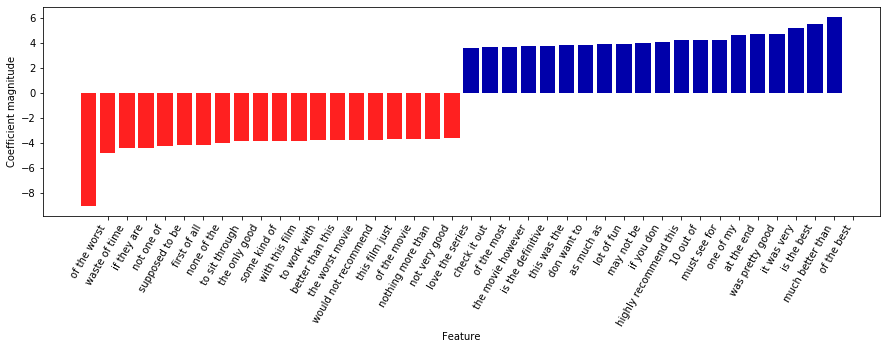

In [29]:
# 找到三元分词特征
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# 仅将三元分词特征可视化
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
    feature_names[mask], n_top_features=20)

# 词干提取与词形还原

用于将同一单词的不同形式用其基本形式表示，减少编码维度

- 词干提取(stemming)：基于规则的启发方法实现，如删除后缀，精简后的单词形式称为词干(stem)
- 词形还原(lemmatization)：基于单词字典的方式实现，单词的标准化形式称为词元(lemma)

词干提取使用nltk中的Porter词干提取器

词形还原使用spacy实现

## 测试词干提取与词形还原效果

In [138]:
import spacy
import nltk

# 加载spacy的英文模型
# 需要预先下载spacy英文模型 python3 -m spacy download en --user
stemmer = nltk.PorterStemmer()
en_nlp = spacy.load("en")

def compare_normalization(doc):
    # 在spacy中对文档进行分词
    doc_spacy = en_nlp(doc)
    # 打印词干提取内容
    print('Stemming')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])
    # 打印出spacy找到的词元
    print('Lemmatization:')
    print([token.lemma_ for token in doc_spacy])

#测试词干提取与词词形还原的效果
compare_normalization('Our meeting today was worse than yesterday,'
                      'I\'m scared of meeting the clients tomorrow.')

Stemming
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', "i'm", 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', "I'm", 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


## 在sklearn Vectorizer中使用外部高级分词

### 自定义用户分词器

In [244]:
# 定义新的分词器
# 使用正则分词规则 + spacy 词形还原
import re

# 基于spacy，将其分词器替换为正则分词
en_nlp = spacy.load('en')
regexp = re.compile('(?u)\\b\\w\\w+\\b')
old_tokenizer = en_nlp.tokenizer
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

import time
# 用spacy文档处理管道创建一个自定义分类器
def custom_tokenizer(document):
    doc_spacy = en_nlp.tokenizer(document)
    rst = [token.lemma_ for token in doc_spacy]
    return rst

### 应用于词袋编码

In [246]:
# 10 min
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)
X_train_lemma = lemma_vect.fit_transform(text_train)
print('info of X_train_lemma')
feature_names = lemma_vect.get_feature_names()
print('num of features:', len(feature_names))
print('First 20 features:\n', feature_names[:20])
print('2000-20020 features:\n', feature_names[20000: 20020])
print('Every 2000th feature:\n', feature_names[::2000])

info of X_train_lemma
num of features: 20658
First 20 features:
 ['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103']
2000-20020 features:
 ['warmth', 'warn', 'warner', 'warners', 'warning', 'warp', 'warrant', 'warren', 'warrior', 'wart', 'warthog', 'wartime', 'warwick', 'wary', 'wash', 'washington', 'washy', 'wasn', 'wasnt', 'wasp']
Every 2000th feature:
 ['00', 'besiege', 'connect', 'eliminate', 'graveyard', 'jigsaw', 'miscast', 'platoon', 'santo', 'sweetness', 'warmth']


In [247]:
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid.fit(X_train_lemma, y_train)
print("Best cross-validation score: ", grid.best_score_)

Best cross-validation score:  0.88204


# 主题建模与文档聚类

常用的方法是**隐含狄利克雷分布(Latent Dirichlet Allocation, LDA)**

这里的LDA不是线性判别分析(LDA)

## 10个主题的建模

In [34]:
# 删除在15%的文档中出现的单词， 最多取10000个
# 6 min
vect = CountVectorizer(max_df=.15, max_features=10000)
X = vect.fit_transform(text_train)
print('info of X', repr(X))

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method='batch', max_iter=25, random_state=0)

document_topics = lda.fit_transform(X)

info of X <25000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 1948677 stored elements in Compressed Sparse Row format>


学习到的components_维数为（主题数目，词典单词数目），代表每个主题下单词权重

In [35]:
lda.components_.shape

(10, 10000)

查看每个主题下的主要特征(单词)

In [95]:
# 对每一行(主题)进行降序排序
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
# print(sorting.dtype)
# # 打印前10个主题
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
             sorting=sorting, topics_per_chunk=5,
             n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

## 100个主题的建模

In [77]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method='batch', max_iter=25, random_state=0)

document_topics100 = lda100.fit_transform(X)

### 人工分析主题内容

In [120]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])

sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
             sorting=sorting, topics_per_chunk=5,
             n_words=10)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
thriller      worst         german        car           beautiful     
suspense      awful         hitler        gets          young         
horror        boring        nazi          guy           old           
atmosphere    horrible      midnight      around        romantic      
mystery       stupid        joe           down          between       
house         thing         germany       kill          romance       
director      terrible      years         goes          wonderful     
quite         script        history       killed        heart         
bit           nothing       new           going         feel          
de            worse         modesty       house         year          


topic 36      topic 37      topic 45      topic 51      topic 53      
--------      --------      --------      --------      --------      
perf

每个主题下的单词相关性比较高，主题45可能与音乐电影相关，下面展示按照主题45进行排序后的文档

In [121]:
# 按主题45进行排序
music = np.argsort(document_topics100[:, 45])[::-1]
# 查看前5条评论
for id in music[:5]:
    print('='*40 + 'doc id' + '='*40)
    print(text_train[id].decode())

========================================doc id========================================
I love this movie and never get tired of watching. The music in it is great. Any true hard rock fan should see this movie and buy the soundtrack. With rockers like Gene Simmons and Ozzy Osbourne you can't go wrong.
========================================doc id========================================
I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try. They start by playing some gigs in some seedy European venues, with hilarious results. The music is fantastic, the script and acting are terrific. The characters are spot on, especially the lead singer with the high heavy metal voice, makeup and personality problems. The concert at the end was unreal. Go and see it, preferably in a cinema with a good sound system :)
========================================doc id========================================
Hollywood Hotel was the last 

### 主题词平均排序获取主题内容

(25000, 100)


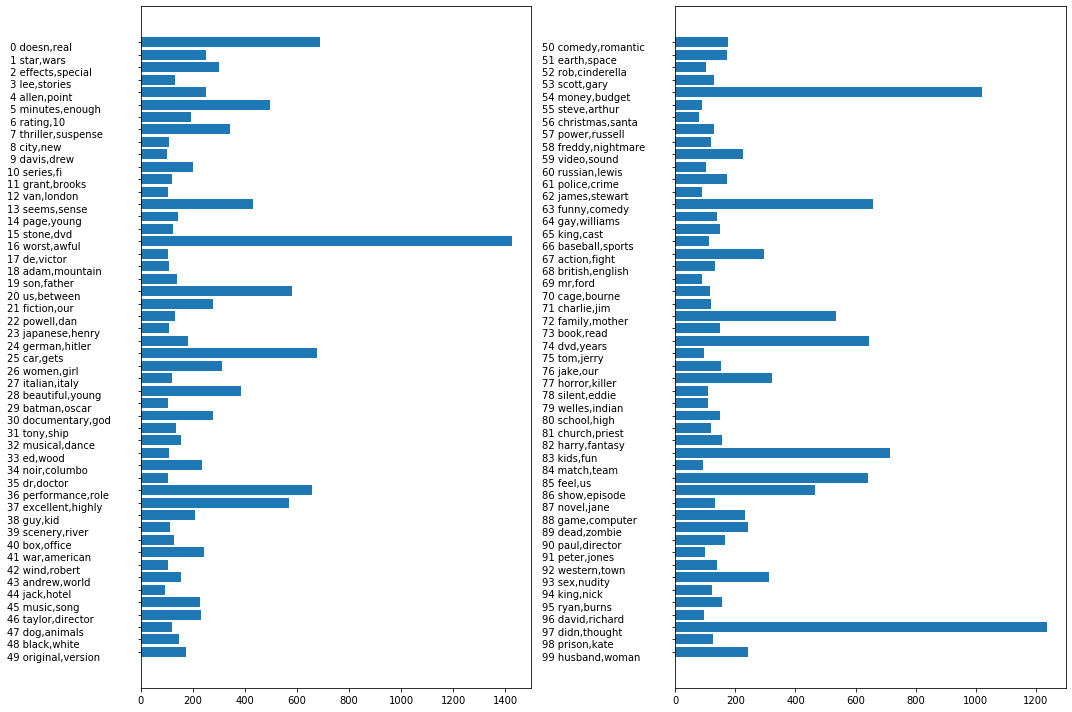

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
topic_names = [ '{:2} {}'.format(id, ','.join(words)) 
                for id, words in enumerate(feature_names[sorting[:, :2]])]
print(document_topics100.shape)
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start: end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start: end], ha='left', va='top')
    ax[col].invert_yaxis()
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
plt.show()